# Load modules and raster data

In [1]:
# Import Python  print function and division
from __future__ import print_function, division

# Import GDAL, NumPy, and matplotlib
from osgeo import gdal, gdal_array
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

In [2]:
# Block warnings messages
import warnings
warnings.filterwarnings('ignore')

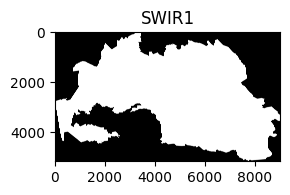

In [3]:
# Read in our image and ROI image
img_ds = gdal.Open('./../../04_classification of ChEZ landscapes/04_input/clip_united_2019.tif', gdal.GA_ReadOnly)

# Copy the transformation to a variable
GT_input = img_ds.GetGeoTransform()

img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()

# Display them
plt.subplot(121)
plt.imshow(img[:, :, 4], cmap=plt.cm.Greys_r)
plt.title('SWIR1')

plt.show()

# Prepocessing of input data and load XGB model

In [4]:
# We will need a "X" matrix containing our features, and a "y" array containing our labels

X = img[:, :, [0, 3, 7, 9, 10]]

print('Our X matrix is sized: {sz}'.format(sz=X.shape))

Our X matrix is sized: (5161, 9008, 5)


In [5]:
#  Importing the main library for building model and its analysis

import xgboost as xgb
import pandas as pd

In [7]:
# Load learned model
xgb_model = xgb.XGBRegressor()

xgb_model.load_model('./XGBoost_models/04_LN_Tag_Sr_SENTINEL_2019_XGB_model_2024_final.json')

In [8]:
# Show all parameters of XGBoost model

print(xgb_model)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.752002626894473, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=['rmse'], feature_types=None,
             gamma=0.11989669723875046, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.03080239065859549, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=104, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)


# Est. biomass of all interest territory

In [9]:
# Take our full image, ignore the Fmask band, and reshape into long 2d array (nrow * ncol, nband) for classification
new_shape = (X.shape[0] * X.shape[1], X.shape[2])

img_as_array = X.reshape(new_shape)
print('Reshaped from {o} to {n}'.format(o=X.shape,
                                        n=img_as_array.shape))

Reshaped from (5161, 9008, 5) to (46490288, 5)


In [10]:
# Create predict values for each pixels
pred_LN = xgb_model.predict(img_as_array, ntree_limit=xgb_model.best_ntree_limit)

# Transform logarithmic values to standard type
pred = np.exp(pred_LN)

# Reshape ourpredict map
pred = pred.reshape(X[:, :, 0].shape)

# Save prediction raster

In [11]:
# Import library
import rasterio

In [13]:
# Save output raster
from affine import Affine
af_transf = Affine.from_gdal(*GT_input)

with rasterio.open(
    './Rasters/04_Tag_Cs_map_2019_2024.tif',
    'w',
    driver='GTiff',
    height=pred.shape[0],
    width=pred.shape[1],
    count=1,
    dtype=np.float32,
    transform=af_transf
) as dest_file:
    dest_file.write(pred, 1)
dest_file.close()